In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.rust_experiment_handler import RustExperiment, Parameter
from src.rust_montecarlo_data_handler import RustMonteCarloData

In [77]:
def get_default_monte_carlo_parameters(lengths: list[int]) -> tuple[dict, dict]:
    """Parameters optimized for my machine (8Gb RAM, quadcore 2Ghz CPU (intel i7 8thGen))"""
    """Feel free to adapt for your machine"""
    
    thermalisation_steps = dict()
    measurement_steps    = dict()
    for L in lengths:
        if L <= 64:
            thermalisation_steps[L] = int(5e5)
            measurement_steps[L]    = int(5e5)
        elif L<= 128:
            thermalisation_steps[L] = int(1e5)
            measurement_steps[L]    = int(1e5)
        elif L<= 512:
            thermalisation_steps[L] = int(1e4) #1e3; 512 -> 4min // 1e4;512 -> 20
            measurement_steps[L]    = int(1e4)
        else:
            thermalisation_steps[L] = int(1e3) #1e2; 1024 -> 2mi
            measurement_steps[L]    = int(1e3)
    return (thermalisation_steps, measurement_steps)

## Perform Monte-Carlo calculation:

In [78]:
folder          = "results"
experiment_name = "overview"
temperatures    = np.arange(0.5, 4.5, 0.05)
lengths         = [8, 16, 32, 64, 128]

(therm_steps, measure_steps) = get_default_monte_carlo_parameters(lengths)

overview = RustExperiment.new_from_parameters(experiment_name, folder, therm_steps, measure_steps, temperatures)

if not overview.are_parameter_files_available():
    overview.write_parameter_files() 

>> Directory "results/overview" Found.
>> Setting file paths:
-- setting paramfile "results/overview/parameter_8x8.txt"
-- setting paramfile "results/overview/parameter_16x16.txt"
-- setting paramfile "results/overview/parameter_32x32.txt"
-- setting paramfile "results/overview/parameter_64x64.txt"
-- setting paramfile "results/overview/parameter_128x128.txt"
-- setting outfile "results/overview/out_8x8.txt"
-- setting outfile "results/overview/out_16x16.txt"
-- setting outfile "results/overview/out_32x32.txt"
-- setting outfile "results/overview/out_64x64.txt"
-- setting outfile "results/overview/out_128x128.txt"
>> Monte Carlo parameters set!
>> Temperatures set!
>> Looking for parameter files:
-- Found parameter file: "results/overview/parameter_8x8.txt"
-- Found parameter file: "results/overview/parameter_16x16.txt"
-- Found parameter file: "results/overview/parameter_32x32.txt"
-- Found parameter file: "results/overview/parameter_64x64.txt"
-- Found parameter file: "results/overvi

In [ ]:
print(f"\nLaunch the simulations: for {overview.lengths}")
for L in overview.lengths:
    if not overview.has_output(L):
        overview.perform_rust_calculation(L)


Launch the simulations: for [8, 16, 32]
Command: "cargo run --release -- results/overview/parameter_8x8.txt"
 * From Rust:     Finished `release` profile [optimized] target(s) in 0.07s
 * From Rust:      Running `target\release\swendsen_wang.exe results/overview/parameter_8x8.txt`
 * From Rust: Setting temperature t=0 => 0.000001
 * From Rust: Launching Swendsen-Wang simulation for N:8x8 with therm steps 500000 & measure_steps: 500000
 * From Rust: Using: 80 temperatures values from 0.000001 to 3.95
 * From Rust: Measuring correlation length: false
 * From Rust: Time taken: 45s
 * From Rust: File saved as results/overview/out_8x8.txt
=> execution successful.

Command: "cargo run --release -- results/overview/parameter_16x16.txt"
 * From Rust:     Finished `release` profile [optimized] target(s) in 0.16s
 * From Rust:      Running `target\release\swendsen_wang.exe results/overview/parameter_16x16.txt`
 * From Rust: Setting temperature t=0 => 0.000001
 * From Rust: Launching Swendsen-Wa

In [39]:
print(f"\nLaunch the simulations: for {overview.lengths[3:4]}")
for L in overview.lengths[3:4]:
    if not overview.has_output(L):
        overview.perform_rust_calculation(L)


Launch the simulations: for [64]
Command: "cargo run --release -- results/overview/parameter_64x64.txt"
 * From Rust:     Finished `release` profile [optimized] target(s) in 0.09s
 * From Rust:      Running `target\release\swendsen_wang.exe results/overview/parameter_64x64.txt`
 * From Rust: Setting temperature t=0 => 0.000001
 * From Rust: Launching Swendsen-Wang simulation for N:64x64 with therm steps 500000 & measure_steps: 500000
 * From Rust: Using: 80 temperatures values from 0.000001 to 3.95
 * From Rust: Measuring correlation length: false
 * From Rust: Time taken: 4319s
 * From Rust: File saved as results/overview/out_64x64.txt
=> execution successful.



Load & plot from file:

### Plot!

In [79]:
results = overview.get_results()
temps   = overview.temperatures


Found output: "results/overview/out_8x8.txt
Found output: "results/overview/out_16x16.txt
Found output: "results/overview/out_32x32.txt
Found output: "results/overview/out_64x64.txt
>> Elapsed time for size 8x8: 0.75min (45.0s)
>> Elapsed time for size 16x16: 3.63min (218.0s)
>> Elapsed time for size 32x32: 15.9min (952.0s)
>> Elapsed time for size 64x64: 72.0min (4319.0s)


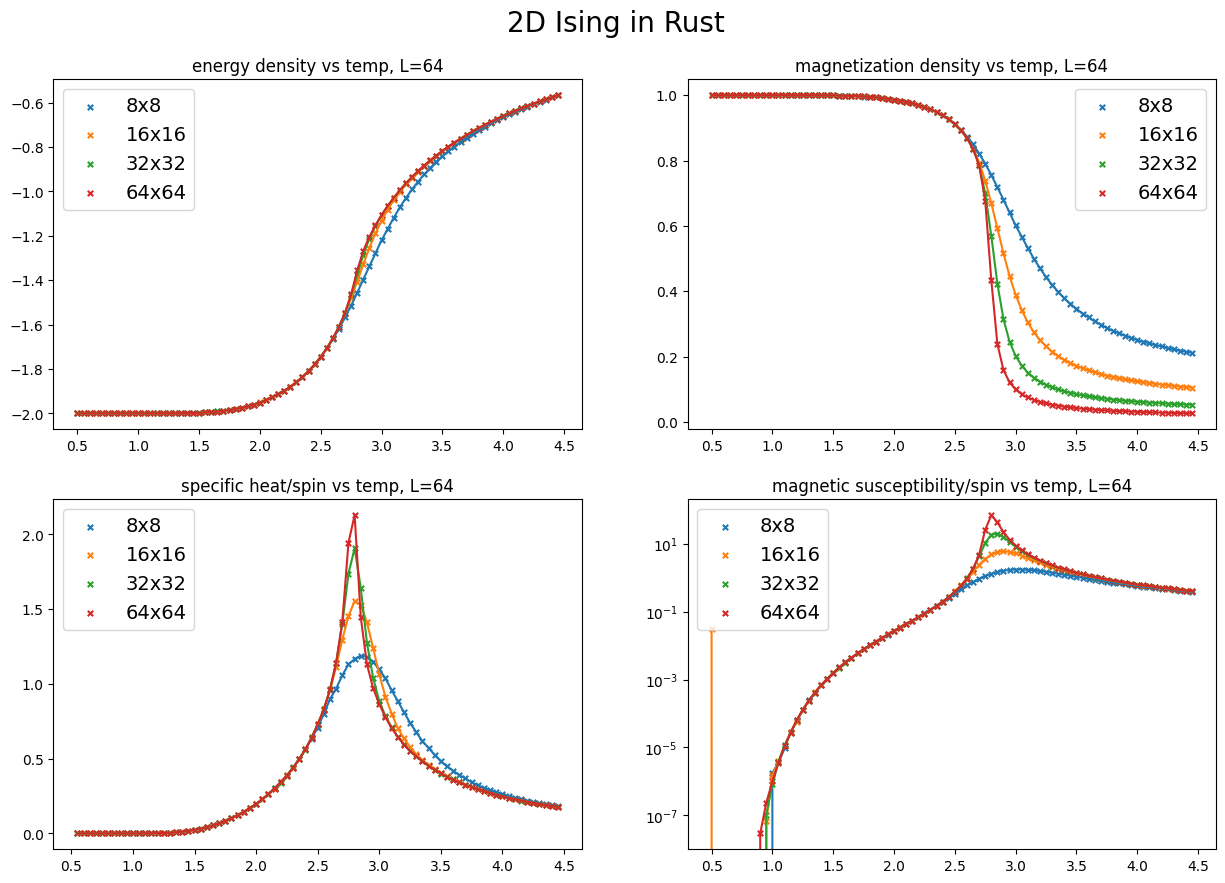

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

fig.suptitle(f"2D Ising in Rust", y=0.95, fontsize=20)
for (L, res) in results.items():
    
    ax1.scatter(temps, res.energy_density, s=15, marker= 'x', label=f"{L}x{L}")
    ax1.plot(temps, res.energy_density)#, label="Rust" )
    ax1.set_title(f"energy density vs temp, L={L}")
    ax1.legend(loc="upper left",fontsize=14)

    ax2.scatter(temps, res.magnetisation, s=15, marker= 'x', label=f"{L}x{L}")
    ax2.plot(temps, res.magnetisation)#, label="Rust")
    ax2.set_title(f"magnetization density vs temp, L={L}")
    ax2.legend(loc="upper right",fontsize=14)

    ax3.scatter(temps[1:], res.specific_heat[1:], s=15, marker= 'x', label=f"{L}x{L}")
    ax3.plot(temps[1:], res.specific_heat[1:])#, label="Rust")
    ax3.set_title(f"specific heat/spin vs temp, L={L}")
    ax3.legend(loc="upper left",fontsize=14)

    ax4.scatter(temps, res.mag_susceptibility, s=15, marker= 'x', label=f"{L}x{L}")
    ax4.semilogy(temps, res.mag_susceptibility)
    ax4.set_title(f"magnetic susceptibility/spin vs temp, L={L}")
    ax4.legend(loc="upper left",fontsize=14)

# Critical point

In [ ]:
folder              = "results"
critical_experiment = "critical_point"

In [ ]:
lengths_Tc = [8, 16, 32, 64, 128]

temps_Tc1 = np.array([1.9 + i*0.02 for i in range(10)])
temps_Tc2 = np.array([2.1 + i*0.01 for i in range(40)])
temps_Tc3 = np.array([2.5 + i*0.02 for i in range(14)]) #8 cores
temps_Tc  = np.concatenate((temps_Tc1, temps_Tc2, temps_Tc3))
print(f"For 8 cores: {len(temps_Tc)} temp values")

(therm_steps_Tc, measure_steps_Tc) = get_default_monte_carlo_parameters(lengths)

        
critical_exp = RustExperiment.new_from_parameters(critical_experiment, folder, therm_steps_Tc, measure_steps_Tc, temps_Tc)
critical_exp.should_measure_struct_fact(True)

if not critical_exp.are_parameter_files_available():
    critical_exp.write_parameter_files() 

For 8 cores: 64 temp values
>> Directory "results/critical_point" Found.
>> setting paramfile "results/critical_point/parameter_8x8.txt"
>> setting outfile "results/critical_point/out_8x8.txt"
>> setting paramfile "results/critical_point/parameter_16x16.txt"
>> setting outfile "results/critical_point/out_16x16.txt"
>> setting paramfile "results/critical_point/parameter_32x32.txt"
>> setting outfile "results/critical_point/out_32x32.txt"
>> setting paramfile "results/critical_point/parameter_64x64.txt"
>> setting outfile "results/critical_point/out_64x64.txt"
>> setting paramfile "results/critical_point/parameter_128x128.txt"
>> setting outfile "results/critical_point/out_128x128.txt"
>> Monte Carlo parameters set!
>> Temperatures set!
Found parameter file: "results/critical_point/parameter_8x8.txt
Found parameter file: "results/critical_point/parameter_16x16.txt
Found parameter file: "results/critical_point/parameter_32x32.txt
Found parameter file: "results/critical_point/parameter_64x

True

In [17]:
critical_results = critical_exp.get_results()
temps            = critical_exp.temperatures


Found output: "results/critical_point/out_8x8.txt
>> Elapsed time for size 8x8: 0.683min (41.0s)
Found output: "results/critical_point/out_16x16.txt
>> Elapsed time for size 16x16: 2.93min (176.0s)
Found output: "results/critical_point/out_32x32.txt
>> Elapsed time for size 32x32: 15.5min (929.0s)
Found output: "results/critical_point/out_64x64.txt
>> Elapsed time for size 64x64: 59.2min (3555.0s)
Found output: "results/critical_point/out_128x128.txt
>> Elapsed time for size 128x128: 38.5min (2313.0s)


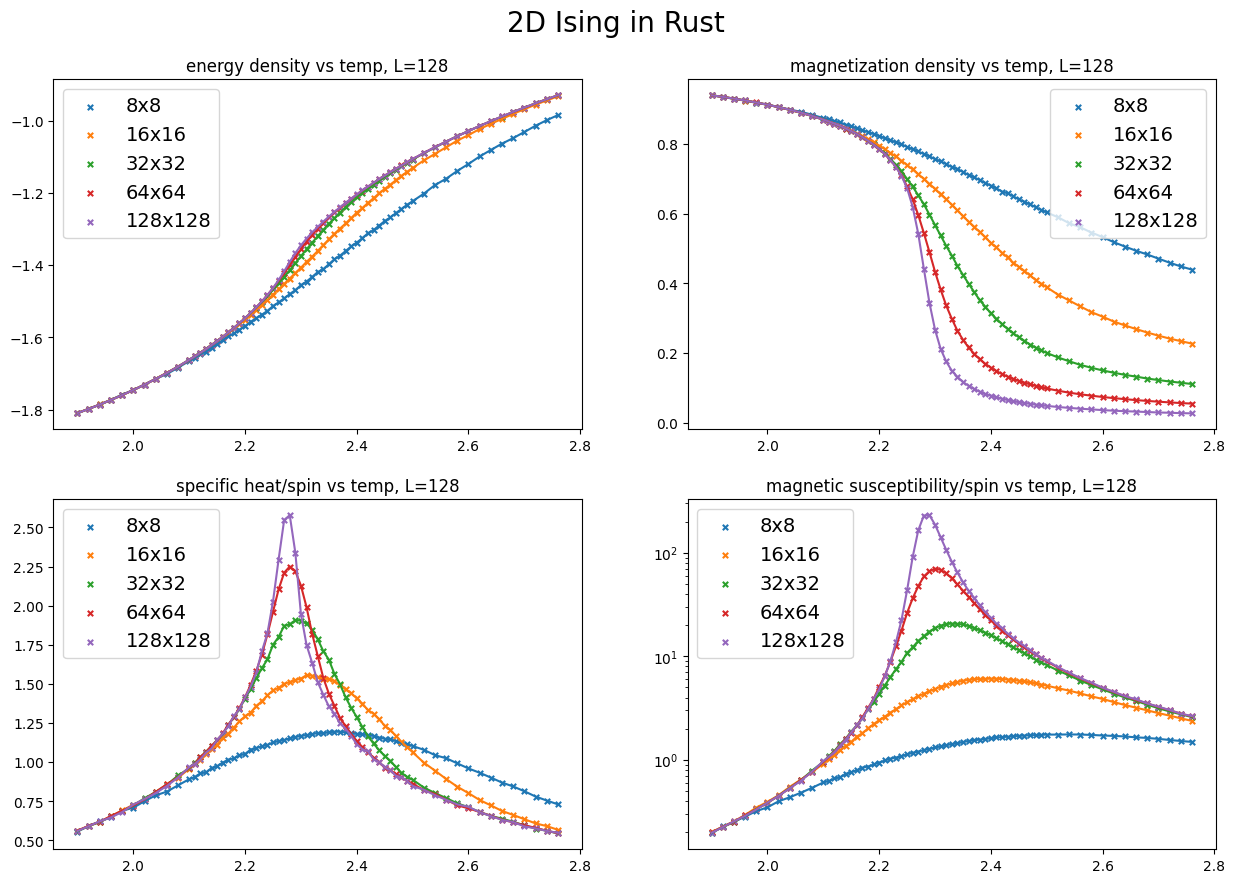

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))



fig.suptitle(f"2D Ising in Rust", y=0.95, fontsize=20)
for (L, result) in critical_results.items():
    
    ax1.scatter(temps, result.energy_density, s=15, marker= 'x', label=f"{L}x{L}")
    ax1.plot(temps, result.energy_density)#, label="Rust" )
    ax1.set_title(f"energy density vs temp, L={L}")
    ax1.legend(loc="upper left",fontsize=14)

    ax2.scatter(temps, result.magnetisation, s=15, marker= 'x', label=f"{L}x{L}")
    ax2.plot(temps, result.magnetisation)#, label="Rust")
    ax2.set_title(f"magnetization density vs temp, L={L}")
    ax2.legend(loc="upper right",fontsize=14)

    ax3.scatter(temps, result.specific_heat, s=15, marker= 'x', label=f"{L}x{L}")
    ax3.plot(temps, result.specific_heat)#, label="Rust")
    ax3.set_title(f"specific heat/spin vs temp, L={L}")
    ax3.legend(loc="upper left",fontsize=14)

    ax4.scatter(temps, result.mag_susceptibility, s=15, marker= 'x', label=f"{L}x{L}")
    ax4.semilogy(temps, result.mag_susceptibility)
    ax4.set_title(f"magnetic susceptibility/spin vs temp, L={L}")
    ax4.legend(loc="upper left",fontsize=14)

# Lets go to bigger sizes:

In [ ]:
folder     = "results"
experiment = "size_limit"

In [71]:
def get_sizing_params(lengths: list[int]) -> tuple[dict, dict]:
    """Parameters optimized for my machine (8Gb RAM, quadcore 2Ghz CPU (intel i7 8thGen))"""
    """Feel free to adapt for your machine"""
    
    thermalisation_steps = dict()
    measurement_steps    = dict()
    for L in lengths:
        if L <= 64:
            thermalisation_steps[L] = int(1e4)
            measurement_steps[L]    = int(1e4)
        elif L<= 128:
            thermalisation_steps[L] = int(1e4)
            measurement_steps[L]    = int(1e4)
        elif L<= 512:
            thermalisation_steps[L] = int(1e3) #1e3; 512 -> 4min // 1e4;512 -> 20
            measurement_steps[L]    = int(1e3)
        else:
            thermalisation_steps[L] = int(1e2)
            measurement_steps[L]    = int(1e2)
    return (thermalisation_steps, measurement_steps)

In [89]:
lengths = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

# temp1 = np.array([0.5   + i*0.25 for i in range(9)])
# temp2 = np.array([2.025 + i*0.025 for i in range(29)])
# temp3 = np.array([2.75 + i*0.25 for i in range(6)])
# temperatures =  np.concatenate( (temp1, temp2, temp3) ) 
temperatures = np.array([1.7 + i*0.02 for i in range(56)])

(thermalisation_steps, measurement_steps) = get_sizing_params(lengths)
            
size_exp = RustExperiment.new_from_parameters(experiment, folder, thermalisation_steps, measurement_steps, temperatures)
# if not size_exp.are_parameter_files_available():
size_exp.write_parameter_files()

>> Directory "results/size_limit" Found.
>> Setting file paths:
-- setting paramfile "results/size_limit/parameter_4x4.txt"
-- setting paramfile "results/size_limit/parameter_8x8.txt"
-- setting paramfile "results/size_limit/parameter_16x16.txt"
-- setting paramfile "results/size_limit/parameter_32x32.txt"
-- setting paramfile "results/size_limit/parameter_64x64.txt"
-- setting paramfile "results/size_limit/parameter_128x128.txt"
-- setting paramfile "results/size_limit/parameter_256x256.txt"
-- setting paramfile "results/size_limit/parameter_512x512.txt"
-- setting paramfile "results/size_limit/parameter_1024x1024.txt"
-- setting outfile "results/size_limit/out_4x4.txt"
-- setting outfile "results/size_limit/out_8x8.txt"
-- setting outfile "results/size_limit/out_16x16.txt"
-- setting outfile "results/size_limit/out_32x32.txt"
-- setting outfile "results/size_limit/out_64x64.txt"
-- setting outfile "results/size_limit/out_128x128.txt"
-- setting outfile "results/size_limit/out_256x256

In [90]:
for L in size_exp.lengths:
    size_exp.perform_rust_calculation(L)

Command: "cargo run --release -- results/size_limit/parameter_4x4.txt"
 * From Rust:     Finished `release` profile [optimized] target(s) in 0.30s
 * From Rust:      Running `target\release\swendsen_wang.exe results/size_limit/parameter_4x4.txt`
 * From Rust: Launching Swendsen-Wang simulation for N:4x4 with therm steps 10000 & measure_steps: 10000
 * From Rust: Using: 56 temperatures values from 1.7 to 2.8
 * From Rust: Measuring correlation length: false
 * From Rust: Time taken: 0s
 * From Rust: File saved as results/size_limit/out_4x4.txt
=> execution successful.

Command: "cargo run --release -- results/size_limit/parameter_8x8.txt"
 * From Rust:     Finished `release` profile [optimized] target(s) in 0.09s
 * From Rust:      Running `target\release\swendsen_wang.exe results/size_limit/parameter_8x8.txt`
 * From Rust: Launching Swendsen-Wang simulation for N:8x8 with therm steps 10000 & measure_steps: 10000
 * From Rust: Using: 56 temperatures values from 1.7 to 2.8
 * From Rust: 

In [91]:
size_results = size_exp.get_results()
temps        = size_exp.temperatures


Found output: "results/size_limit/out_4x4.txt
Found output: "results/size_limit/out_8x8.txt
Found output: "results/size_limit/out_16x16.txt
Found output: "results/size_limit/out_32x32.txt
Found output: "results/size_limit/out_64x64.txt
Found output: "results/size_limit/out_128x128.txt
Found output: "results/size_limit/out_256x256.txt
Found output: "results/size_limit/out_512x512.txt
Found output: "results/size_limit/out_1024x1024.txt
>> Elapsed time for size 4x4: 0.0min (0.0s)
>> Elapsed time for size 8x8: 0.0min (0.0s)
>> Elapsed time for size 16x16: 0.0333min (2.0s)
>> Elapsed time for size 32x32: 0.15min (9.0s)
>> Elapsed time for size 64x64: 0.683min (41.0s)
>> Elapsed time for size 128x128: 3.33min (200.0s)
>> Elapsed time for size 256x256: 1.47min (88.0s)
>> Elapsed time for size 512x512: 6.73min (404.0s)
>> Elapsed time for size 1024x1024: 3.12min (187.0s)


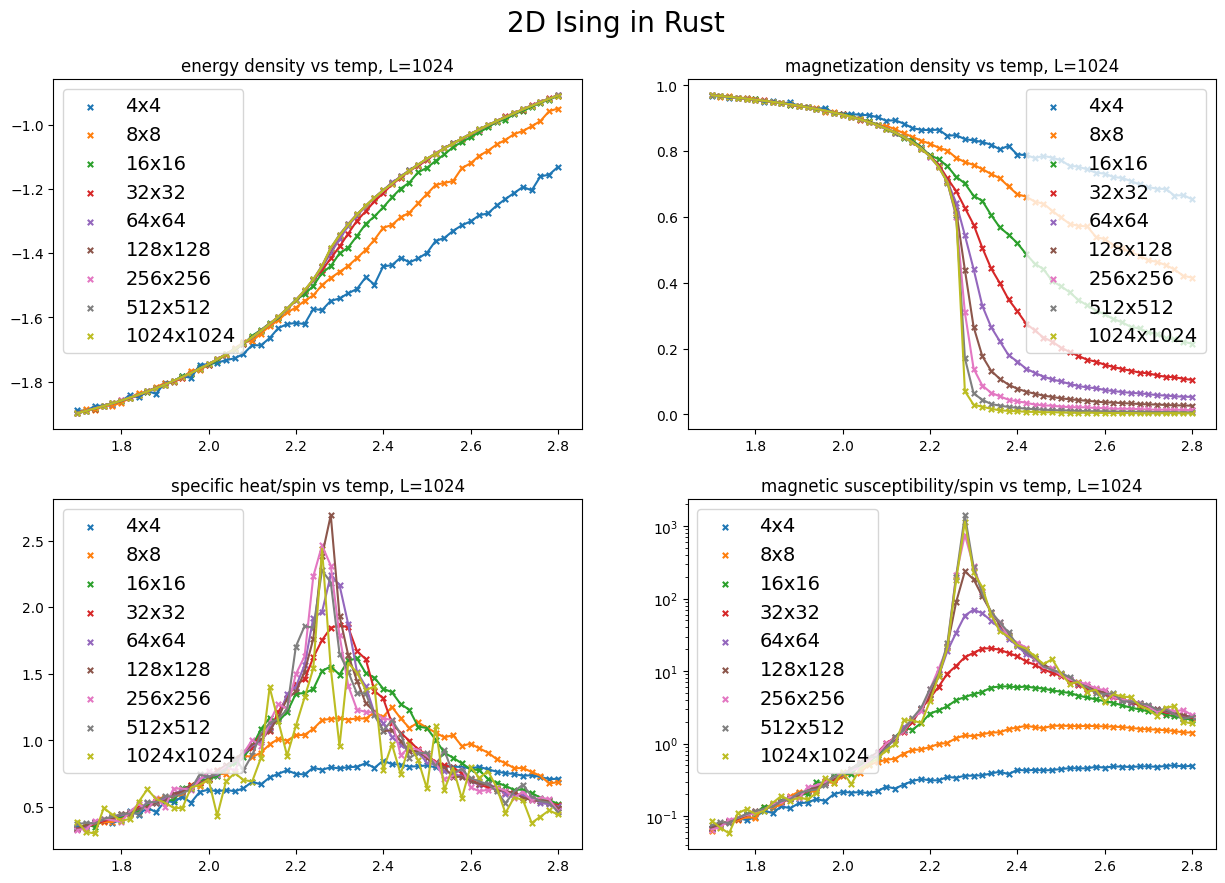

In [92]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

fig.suptitle(f"2D Ising in Rust", y=0.95, fontsize=20)
for (L, res) in size_results.items():
    
    ax1.scatter(temps, res.energy_density, s=15, marker= 'x', label=f"{L}x{L}")
    ax1.plot(temps, res.energy_density)#, label="Rust" )
    ax1.set_title(f"energy density vs temp, L={L}")
    ax1.legend(loc="upper left",fontsize=14)

    ax2.scatter(temps, res.magnetisation, s=15, marker= 'x', label=f"{L}x{L}")
    ax2.plot(temps, res.magnetisation)#, label="Rust")
    ax2.set_title(f"magnetization density vs temp, L={L}")
    ax2.legend(loc="upper right",fontsize=14)

    ax3.scatter(temps, res.specific_heat, s=15, marker= 'x', label=f"{L}x{L}")
    ax3.plot(temps, res.specific_heat)#, label="Rust")
    ax3.set_title(f"specific heat/spin vs temp, L={L}")
    ax3.legend(loc="upper left",fontsize=14)

    ax4.scatter(temps, res.mag_susceptibility, s=15, marker= 'x', label=f"{L}x{L}")
    ax4.semilogy(temps, res.mag_susceptibility)
    ax4.set_title(f"magnetic susceptibility/spin vs temp, L={L}")
    ax4.legend(loc="upper left",fontsize=14)

In [88]:
temp3 = np.array([1.7 + i*0.02 for i in range(56)])
temp3

array([1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 ,
       1.92, 1.94, 1.96, 1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12,
       2.14, 2.16, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34,
       2.36, 2.38, 2.4 , 2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56,
       2.58, 2.6 , 2.62, 2.64, 2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78,
       2.8 ])